# Predicting Length Of Stay (LOS) at the ICU using Machine Learning

## Group C - Members

- Bárbara Neto - up202106176@edu.fc.up.pt
- João Varelas - up201609013@edu.fc.up.pt
- Leandro Costa - up202408816@edu.fc.up.pt

## **Introduction**  

This work focuses on predicting ICU length of stay (LOS) using the **MIMIC-III** dataset, a large-scale collection of electronic health records from over **26,000 ICU patients**. The dataset includes diverse clinical variables such as vital signs, lab results, and treatment records, presenting both temporal and high-dimensional challenges. Given the volume and complexity of the data, we employ scalable machine learning techniques to preprocess, model, and interpret predictive patterns. The analysis aims to assist in resource allocation and clinical decision-making while addressing computational constraints inherent in big healthcare data.

Given the dataset's size, traditional single-node tools (e.g., Pandas, Scikit-learn) would be inefficient due to memory and computational limitations. Instead, we leverage **PySpark**  for both Data Processing and Machine Learning.

1. **Scalability** – PySpark efficiently processes large datasets by distributing computations across a cluster, making it ideal for big data workloads.  
2. **In-Memory Processing** – Spark's in-memory execution significantly speeds up iterative operations, crucial for machine learning pipelines.  
3. **Integration with MLlib** – PySpark provides MLlib, a scalable machine learning library that supports preprocessing, feature engineering, and model training on distributed datasets.  
4. **Fault Tolerance & Optimization** – Spark’s lazy evaluation and DAG-based execution optimize performance, while its fault-tolerant design ensures reliability.  
5. **Compatibility with Big Data Ecosystems** – PySpark integrates seamlessly with storage systems (HDFS, S3) and SQL-based tools (Spark SQL), facilitating efficient data handling.  


Our analysis follows a structured machine learning pipeline:  

1. **Load Data & Initialize Session** - Get the data from the Google Cloud Storage.
2. **Exploratory Data Analysis** - Statiscial overview of the data.
3. **Feature Engineering** – Aggregating patient records over a chosen window size to balance predictive power and computational feasibility.  
4. **Data Preprocessing** – Handling missing values, encoding categorical variables, and normalizing features using PySpark’s DataFrame API. 
5. **Model Training & Validation** – Employing distributed ML algorithms via MLlib, with hyperparameter tuning using Cross Validaton.  
6. **Performance Profiling** – Monitoring execution time and resource usage to identify bottlenecks.  
7. **Interpretation of Results** – Evaluating model performance using metrics, discussing feature importance and justifying the chosen window size.  


All experiments were conducted on a **Google Cloud Dataproc cluster** (cluster-f787) deployed in the europe-west2-c zone. The cluster configuration consisted of one master node (n2-standard-4 with 4 vCPUs, 16 GB RAM) and two worker nodes (n2-standard-2 with 2 vCPUs, 8 GB RAM each), providing a total of 8 vCPUs and 32 GB RAM across the distributed environment. The cluster utilized Dataproc image version 2.2.59-debian12 with advanced optimizations enabled, including the advanced execution layer for enhanced Spark performance. Data storage was managed through Google Cloud Storage with a staging bucket, while each node was equipped with standard persistent disks (100 GB for master, 200 GB per worker). This cloud-native setup enabled scalable processing of the large MIMIC-III dataset while providing the computational resources necessary for distributed machine learning workloads.

Key Technical Specifications:
- **Master Node**: n2-standard-4 (4 vCPUs, 16 GB RAM, 100 GB disk)
- **Worker Nodes**: 2x n2-standard-2 (2 vCPUs, 8 GB RAM, 200 GB disk each)
- **Region**: europe-west2-c
- **Image**: Dataproc 2.2.59-debian12
- **Storage**: Google Cloud Storage integration (Buckets)
- **Optimizations**: Advanced execution layer and performance enhancements enabled, Jupyter Notebook project

This infrastructure provided the distributed computing power required to handle the 330M+ CHARTEVENTS records and 22M+ LABEVENTS records efficiently while maintaining fault tolerance and scalability throughout the machine learning pipeline.

By leveraging **PySpark**, we ensure that our pipeline is both scalable and efficient, enabling robust analysis of ICU patient data while maintaining computational feasibility. The following sections detail our approach, results, and key insights.

## **1.** Load Data & Initialize Session

Import needed libraries:
* PySpark SQL
* PySpark ML Features, Functions, Regression, Evaluation & Tuning
* MatPlotLib for Data Visualization
* Datatime and Time
* OS and other system libraries


In [1]:
# =============================================
# 📦 PYSPARK CORE & DATAFRAME OPERATIONS
# =============================================
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.types import *
from pyspark.sql.functions import (
    col,    lit,    sum as sql_sum,    count,    mean,    stddev,    min,    max,
    percentile_approx,    when,    coalesce,    isnull,    datediff,    row_number,
    first,    broadcast,    floor,    udf,    expr
)


# =============================================
# 🔧 DATA PROCESSING & FEATURE ENGINEERING
# =============================================
from pyspark.ml.feature import (
    VectorAssembler,
    StandardScaler,
    StringIndexer,
    MinMaxScaler,
    Imputer,
    Bucketizer
)
from pyspark.ml.functions import vector_to_array


# =============================================
# 🤖 MACHINE LEARNING MODELS
# =============================================
from pyspark.ml.regression import (
    RandomForestRegressor,
    LinearRegression,
    GBTRegressor
)


# =============================================
# 📊 MODEL EVALUATION & HYPERPARAMETER TUNING
# =============================================
from pyspark.ml.evaluation import (
    RegressionEvaluator,
    BinaryClassificationEvaluator
)
from pyspark.ml.tuning import (
    CrossValidator, 
    ParamGridBuilder
)
from pyspark.ml import Pipeline


# =============================================
# 🛠️ UTILITY LIBRARIES
# =============================================
from datetime import datetime, timedelta
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# =============================================
# ⚙️ SYSTEM CONFIGURATION
# =============================================
import os
import sys
import warnings
warnings.filterwarnings('ignore')


print("\n✅ All imports loaded successfully!")
print(f"⏰ Notebook started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🐍 Python version: {sys.version.split()[0]}")
print(f"🔥 Spark version: {SparkSession.builder.getOrCreate().version}\n")


✅ All imports loaded successfully!
⏰ Notebook started at: 2025-06-08 17:28:36
🐍 Python version: 3.11.8


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/08 17:28:41 INFO SparkEnv: Registering MapOutputTracker
25/06/08 17:28:41 INFO SparkEnv: Registering BlockManagerMaster
25/06/08 17:28:41 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
25/06/08 17:28:41 INFO SparkEnv: Registering OutputCommitCoordinator


🔥 Spark version: 3.5.3



## Initialize spark session

In [2]:
spark = SparkSession.builder \
    .appName("Forecast-LOS") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.adaptive.skewJoin.enabled", "true") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    \
    .config("spark.executor.memory", "5g") \
    .config("spark.executor.cores", "2") \
    .config("spark.executor.instances", "2") \
    \
    .config("spark.driver.memory", "10g") \
    .config("spark.driver.cores", "3") \
    .config("spark.driver.maxResultSize", "2g") \
    \
    .config("spark.sql.shuffle.partitions", "32") \
    .config("spark.sql.adaptive.advisoryPartitionSizeInBytes", "64MB") \
    .config("spark.sql.files.maxPartitionBytes", "128MB") \
    .config("spark.sql.adaptive.maxShuffledHashJoinLocalMapThreshold", "32MB") \
    \
    .config("spark.network.timeout", "600s") \
    .config("spark.sql.broadcastTimeout", "300s") \
    .config("spark.rpc.askTimeout", "300s") \
    \
    .config("spark.executor.heartbeatInterval", "20s") \
    .config("spark.dynamicAllocation.enabled", "false") \
    \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.adaptive.localShuffleReader.enabled", "true") \
    .config("spark.sql.adaptive.skewJoin.skewedPartitionThresholdInBytes", "128MB") \
    \
    .config("spark.executor.memoryOffHeap.enabled", "true") \
    .config("spark.executor.memoryOffHeap.size", "1g") \
    \
    .getOrCreate()
print("✅ Spark session created successfully!")
print(f"📊 Spark Version: {spark.version}")
print(f"🔧 Application Name: {spark.sparkContext.appName}")
print(f"💾 Available cores: {spark.sparkContext.defaultParallelism}")
print(f"\n⏰ Spark session initialised at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

GLOBAL_START_TIME = datetime.now()

✅ Spark session created successfully!
📊 Spark Version: 3.5.3
🔧 Application Name: pyspark-shell
💾 Available cores: 2

⏰ Spark session initialised at: 2025-06-08 17:28:49


25/06/08 17:28:49 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Load and prepare the MIMIC-III dataset for analysis in a Spark environment. It first configures data path, then loads ICU stay records and filters related clinical data (vitals, lab results, diagnoses, and demographics) to only include patients with ICU stays.  

**Optimizations:** The script improves performance by caching frequently used ICU stay data, using broadcast joins for efficient table merging, and converting CSV files to parquet format for faster reads. It also supports sampling for smaller test datasets.  

Finally, report row counts for key tables, including filtered ICU stays, patient records, admissions, diagnoses, measurements, and lab results.

In [3]:
MIMIC_PATH = "gs://dataproc-staging-europe-west2-851143487985-hir6gfre/mimic-data"

print("🏥 Loading MIMIC-III data...")

print("📂 Loading CHARTEVENTS...")

try:
   chartevents_df = spark.read.parquet(f"{MIMIC_PATH}/CHARTEVENTS.parquet")
   print("✅ Loaded CHARTEVENTS from parquet")
except:
   print("📄 Converting CHARTEVENTS.csv.gz to parquet...")
   chartevents_csv = spark.read.option("header", "true").option("inferSchema", "false").csv(f"{MIMIC_PATH}/CHARTEVENTS.csv.gz")
   chartevents_csv.write.mode("overwrite").parquet(f"{MIMIC_PATH}/CHARTEVENTS.parquet")
   chartevents_df = spark.read.parquet(f"{MIMIC_PATH}/CHARTEVENTS.parquet")
   print("✅ Converted and loaded CHARTEVENTS")


print("\n📂 Loading and filtering ICUSTAYS...")
icustays_df = spark.read.option("header", "true").option("inferSchema", "true").csv(f"{MIMIC_PATH}/ICUSTAYS.csv.gz")

icustays_df.cache()
actual_sample_size = icustays_df.count()

   
print("📋 Creating ID lookup tables...")
icu_lookup = icustays_df.select("ICUSTAY_ID").distinct().cache()
hadm_lookup = icustays_df.select("HADM_ID").distinct().cache()
subject_lookup = icustays_df.select("SUBJECT_ID").distinct().cache()

icu_lookup.count()  
hadm_lookup.count()
subject_lookup.count()


print("📂 Loading PATIENTS table...")
patients_df = spark.read.option("header", "true").option("inferSchema", "true").csv(f"{MIMIC_PATH}/PATIENTS.csv.gz")
patients_df = patients_df.join(broadcast(subject_lookup), "SUBJECT_ID", "inner")

print("📂 Loading ADMISSIONS table...")
admissions_df = spark.read.option("header", "true").option("inferSchema", "true").csv(f"{MIMIC_PATH}/ADMISSIONS.csv.gz")
admissions_df = admissions_df.join(broadcast(hadm_lookup), "HADM_ID", "inner")

print("📂 Loading DIAGNOSES_ICD table...")
diagnoses_df = spark.read.option("header", "true").option("inferSchema", "true").csv(f"{MIMIC_PATH}/DIAGNOSES_ICD.csv.gz")
diagnoses_df = diagnoses_df.join(broadcast(hadm_lookup), "HADM_ID", "inner")
d_items_df = spark.read.option("header", "true").option("inferSchema", "true").csv(f"{MIMIC_PATH}/D_ITEMS.csv.gz")


print("📂 Loading CHARTEVENTS table... [FILTERING BY ICUSTAY_ID]")
chartevents_df = chartevents_df \
   .select("ICUSTAY_ID", "CHARTTIME", "ITEMID", "VALUE", "VALUEUOM", "VALUENUM") \
   .join(broadcast(icu_lookup), "ICUSTAY_ID", "inner")


print("📂 Loading LABEVENTS table... [FILTERING BY HADM_ID]")
try:
   labevents_df = spark.read.parquet(f"{MIMIC_PATH}/LABEVENTS.parquet")
except:
   print("📄 Converting LABEVENTS.csv.gz to parquet...")
   labevents_csv = spark.read.option("header", "true").option("inferSchema", "false").csv(f"{MIMIC_PATH}/LABEVENTS.csv.gz")
   labevents_csv.write.mode("overwrite").parquet(f"{MIMIC_PATH}/LABEVENTS.parquet")
   labevents_df = spark.read.parquet(f"{MIMIC_PATH}/LABEVENTS.parquet")

d_labitems_df = spark.read.option("header", "true").option("inferSchema", "false").csv(f"{MIMIC_PATH}/D_LABITEMS.csv.gz")
labevents_df = labevents_df.join(broadcast(hadm_lookup), "HADM_ID", "inner")

print("\n✅ Data loading complete!")
print(f"📊 ICUSTAYS: {icustays_df.count():,} rows")
print(f"📊 PATIENTS: {patients_df.count():,} rows") 
print(f"📊 ADMISSIONS: {admissions_df.count():,} rows")
print(f"📊 DIAGNOSES_ICD: {diagnoses_df.count():,} rows")
print(f"📊 CHARTEVENTS (filtered): {chartevents_df.count():,} rows")
print(f"📊 LABEVENTS (filtered): {labevents_df.count():,} rows")
print(f"\n⏰ Data loaded at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

🏥 Loading MIMIC-III data...
📂 Loading CHARTEVENTS...


✅ Loaded CHARTEVENTS from parquet

📂 Loading and filtering ICUSTAYS...


📋 Creating ID lookup tables...


📂 Loading PATIENTS table...
📂 Loading ADMISSIONS table...
📂 Loading DIAGNOSES_ICD table...


📂 Loading CHARTEVENTS table... [FILTERING BY ICUSTAY_ID]
📂 Loading LABEVENTS table... [FILTERING BY HADM_ID]

✅ Data loading complete!
📊 ICUSTAYS: 61,532 rows


📊 PATIENTS: 46,476 rows


📊 ADMISSIONS: 57,786 rows


📊 DIAGNOSES_ICD: 642,624 rows


📊 CHARTEVENTS (filtered): 330,414,954 rows


📊 LABEVENTS (filtered): 22,072,543 rows

⏰ Data loaded at: 2025-06-08 17:30:16


## **2.** Exploratory Data Analysis 

To better understand the clinical interventions administered to patients during their ICU stay, we performed exploratory data analysis (EDA) using the `CHARTEVENTS` and `D_ITEMS` tables from the MIMIC-III dataset.

We began by selecting relevant columns from `CHARTEVENTS.csv`, focusing on:
- `SUBJECT_ID`, `HADM_ID`, `ICUSTAY_ID`
- `ITEMID`, `CHARTTIME`, `VALUE`, `VALUENUM`

Then, we joined this dataset with `D_ITEMS.csv` to map each `ITEMID` to a human-readable `LABEL`, corresponding to the type of medical observation or input (e.g., Glucose, Blood Pressure, etc.).

We filtered the data to include only a specific ICU stay (`ICUSTAY_ID = 271202`), and normalized the timestamps:
- Converted `CHARTTIME` to datetime format.
- Computed relative time from the start of the ICU stay in both hours and days (`DAYS_FROM_START`).

Finally, we filtered out rows where `VALUENUM` was missing, since this column holds the numeric value of the recorded event.

A basic boxplot was generated showing the distribution of all numeric values (`VALUENUM`) recorded during the selected ICU stay. This gives a global view of potential outliers and data dispersion without considering event types.

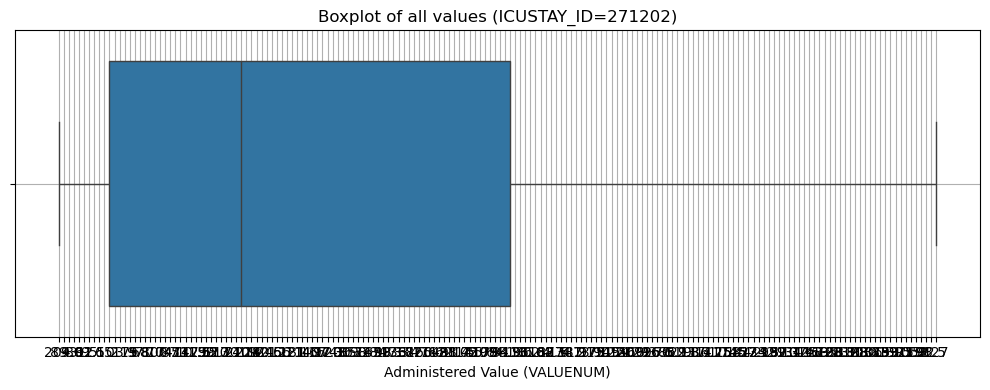

In [4]:
import pyspark.pandas as ps
import matplotlib.pyplot as plt
import seaborn as sns

icustay_id = 271202
stay_df = chartevents_df.filter(chartevents_df['ICUSTAY_ID'] == icustay_id)

# Join `stay_df` with `d_items_df` on 'ITEMID'
stay_df = stay_df.join(d_items_df, on='ITEMID', how='left')

# Convert CHARTTIME to timestamp and calculate time-related features
stay_df = stay_df.withColumn("CHARTTIME", F.to_timestamp("CHARTTIME"))
t0 = stay_df.agg(F.min("CHARTTIME")).collect()[0][0]
stay_df = stay_df.withColumn("HOURS_FROM_START", 
                                (F.unix_timestamp("CHARTTIME") - F.unix_timestamp(F.lit(t0))) / 3600)
stay_df = stay_df.withColumn("DAYS_FROM_START", stay_df["HOURS_FROM_START"] / 24)

# Drop rows with missing 'VALUENUM'
stay_df = stay_df.dropna(subset=['VALUENUM'])

# Sample a small subset (10%) of the data to avoid overloading the driver
#sample_df = stay_df.sample(fraction=0.1, seed=42)  # 10% sample

# Collect the data to the driver (now it's smaller and safe)
#sample_pd_df = sample_df.toPandas()

# Plot the boxplot
plt.figure(figsize=(10, 4))
sns.boxplot(data=stay_df.toPandas(), x='VALUENUM')
plt.title(f"Boxplot of all values (ICUSTAY_ID={icustay_id})")
plt.xlabel("Administered Value (VALUENUM)")
plt.grid(True)
plt.tight_layout()
plt.show()


We identified the 10 most frequent `LABEL`s (medical items) and created a boxplot for each, allowing us to compare the distribution of values across different intervention types. This is particularly useful for spotting abnormal readings or highly variable administrations (e.g., fluids, medication dosages).

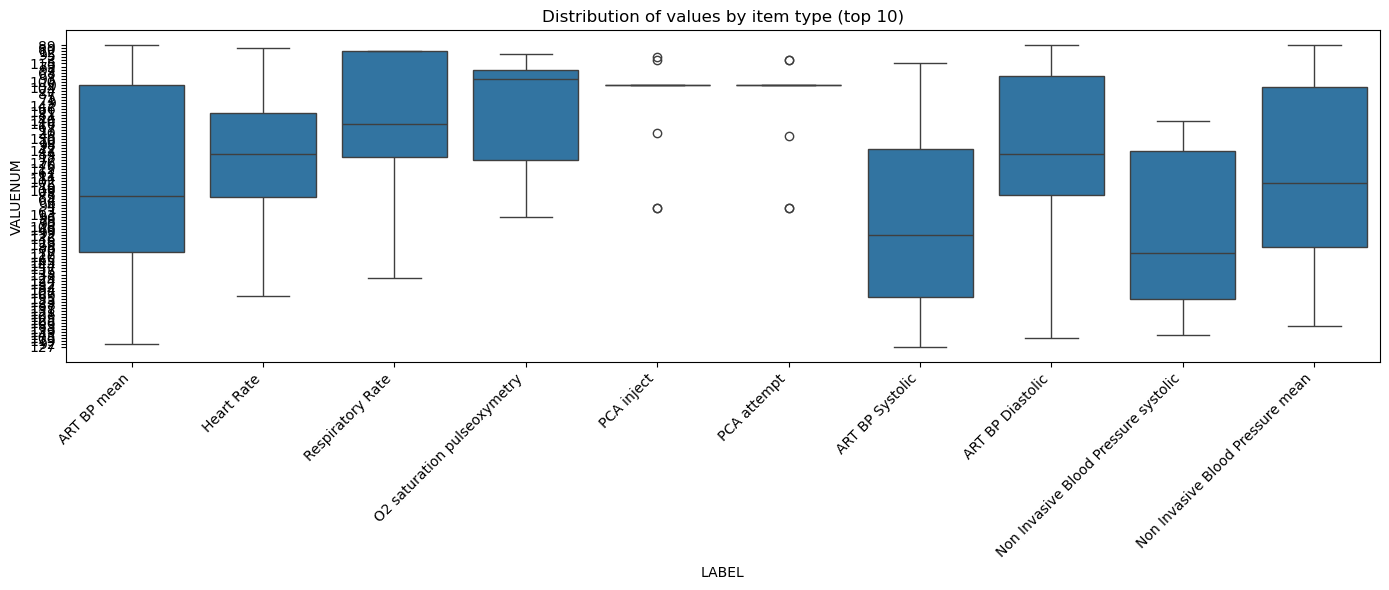

In [5]:
# Drop rows with missing 'VALUENUM'
scatter_df = stay_df.dropna(subset=['VALUENUM'])

# Get the top 10 'LABEL' values based on the frequency of their occurrences
top_items_df = scatter_df.groupBy('LABEL').count().orderBy(F.desc('count')).limit(10)

# Collect the result as a list of the top 10 item labels
top_items = [row['LABEL'] for row in top_items_df.collect()]

# Filter the scatter_df to include only the rows with the top 10 'LABEL' values
box_df = scatter_df.filter(scatter_df['LABEL'].isin(top_items))

# Convert to Pandas DataFrame for plotting (only if the DataFrame is not too large)
box_df_pd = box_df.toPandas()

# Plot the boxplot for the top 10 items
plt.figure(figsize=(14, 6))
sns.boxplot(data=box_df_pd, x='LABEL', y='VALUENUM')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set the title of the plot
plt.title("Distribution of values by item type (top 10)")

# Adjust the layout to avoid clipping
plt.tight_layout()

# Show the plot
plt.show()


To provide a focused view, we filtered and plotted a histogram of `VALUENUM` for entries labeled “Glucose”. This allows for a detailed inspection of blood glucose levels administered or recorded during the ICU stay, which is clinically relevant in many ICU scenarios.


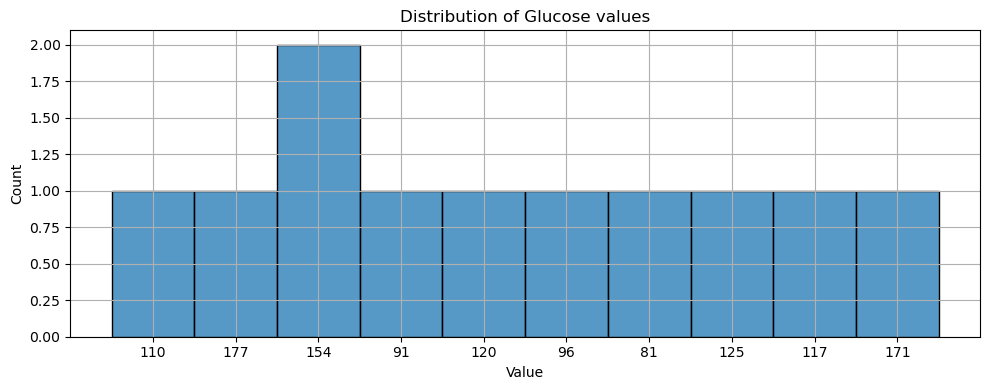

In [6]:
# Histogram of a specific item (Glucose)
item_label = 'Glucose'

# Filter using PySpark DataFrame operations instead of pandas string methods
glucose_df = scatter_df.filter(
    scatter_df['LABEL'].contains(item_label) | 
    scatter_df['LABEL'].like(f'%{item_label.lower()}%') |
    scatter_df['LABEL'].like(f'%{item_label.upper()}%')
).filter(scatter_df['LABEL'].isNotNull())

# Check if DataFrame is empty
glucose_count = glucose_df.count()

if glucose_count == 0:
    print(f"No data found with LABEL containing '{item_label}'.")
else:
    # Convert to regular pandas DataFrame for plotting compatibility
    glucose_pandas_df = glucose_df.toPandas()
    
    plt.figure(figsize=(10, 4))
    sns.histplot(glucose_pandas_df['VALUENUM'], bins=30)
    plt.title(f"Distribution of {item_label} values")
    plt.xlabel("Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In addition to clinical event data, we analyzed the distribution of patient ages in the ICU population. Using `PATIENTS.csv` and `ADMISSIONS.csv`, we computed the age at the time of ICU admission by subtracting the date of birth (`DOB`) from the admission timestamp (`ADMITTIME`).

To ensure consistency and clinical relevance:
- We excluded entries with missing or clearly masked age values (e.g., `AGE > 115`).
- Age was calculated in years, with a valid range of approximately 0 to 115.

 A histogram with kernel density estimation (KDE) was plotted to show the distribution of patient ages. Most ICU admissions fell in the adult and elderly ranges, with a peak typically around 60–70 years.

🕐 Converting datetime columns...
🧹 Filtering extreme birth dates...
🔗 Joining dataframes...
📊 Calculating ages...
📈 Final dataset size: 109528 ICU stays
📊 Converting to pandas for visualization...


🎨 Creating age distribution plot...


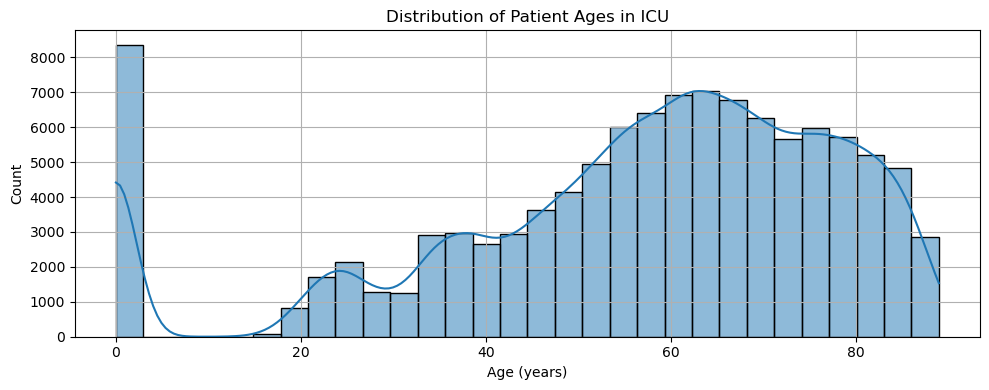

📈 Age Statistics:


+-------+------------------+
|summary|               AGE|
+-------+------------------+
|  count|            109528|
|   mean| 55.78308258743293|
| stddev|22.808907264090916|
|    min|               0.0|
|    max| 89.00158186934368|
+-------+------------------+

👥 Age Groups:
+---------------+-----+
|      AGE_GROUP|count|
+---------------+-----+
|  Adult (18-64)|57213|
|  Elderly (65+)|43847|
|Pediatric (<18)| 8468|
+---------------+-----+



In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, to_timestamp, year, month, dayofmonth, when, isnan, isnull
from pyspark.sql.types import TimestampType
import pyspark.pandas as ps

# Convert to datetime using PySpark functions
print("🕐 Converting datetime columns...")

# Create temporary views for easier manipulation
patients_temp = patients_df.select(
    "SUBJECT_ID", 
    to_timestamp(col("DOB"), "yyyy-MM-dd HH:mm:ss").alias("DOB_TS")
)

admissions_temp = admissions_df.select(
    "SUBJECT_ID",
    to_timestamp(col("ADMITTIME"), "yyyy-MM-dd HH:mm:ss.S").alias("ADMITTIME_TS")
)

# Filter out extreme DOBs (before 1900)
print("🧹 Filtering extreme birth dates...")
patients_filtered = patients_temp.filter(
    col("DOB_TS") >= to_timestamp(lit("1900-01-01"), "yyyy-MM-dd")
)

# Merge dataframes
print("🔗 Joining dataframes...")
df_spark = icustays_df.select("ICUSTAY_ID", "SUBJECT_ID", "HADM_ID", "LOS") \
    .join(admissions_temp, "SUBJECT_ID", "left") \
    .join(patients_filtered, "SUBJECT_ID", "left")

# Remove rows with null timestamps
df_spark = df_spark.filter(
    col("DOB_TS").isNotNull() & col("ADMITTIME_TS").isNotNull()
)

# Calculate age in years
print("📊 Calculating ages...")
df_spark = df_spark.withColumn(
    "AGE", 
    (col("ADMITTIME_TS").cast("long") - col("DOB_TS").cast("long")) / (365.25 * 24 * 3600)
)

# Filter reasonable ages (0-115 years)
df_spark = df_spark.filter(col("AGE").between(0, 115))

print(f"📈 Final dataset size: {df_spark.count()} ICU stays")

# Convert to pandas using PySpark pandas API for plotting
print("📊 Converting to pandas for visualization...")
df_pandas = df_spark.select("AGE").toPandas()

# Create the plot
print("🎨 Creating age distribution plot...")
plt.figure(figsize=(10, 4))
sns.histplot(df_pandas['AGE'], bins=30, kde=True)
plt.title("Distribution of Patient Ages in ICU")
plt.xlabel("Age (years)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Additional statistics
print("📈 Age Statistics:")
age_stats = df_spark.select("AGE").describe()
age_stats.show()

print("👥 Age Groups:")
age_groups = df_spark.withColumn(
    "AGE_GROUP",
    when(col("AGE") < 18, "Pediatric (<18)")
    .when(col("AGE") < 65, "Adult (18-64)")
    .otherwise("Elderly (65+)")
).groupBy("AGE_GROUP").count().orderBy("count", ascending=False)

age_groups.show()

A complementary boxplot was generated to highlight outliers and the interquartile range (IQR) of ages. This helps identify whether the ICU cohort skews older or has a wide age spread.

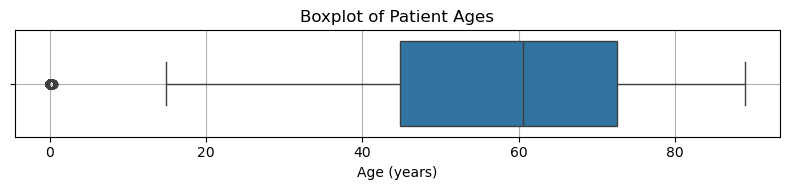

In [8]:
# Plot boxplot
plt.figure(figsize=(8, 2))
sns.boxplot(x=df_pandas['AGE'])
plt.title("Boxplot of Patient Ages")
plt.xlabel("Age (years)")
plt.grid(True)
plt.tight_layout()
plt.show()

Understanding the age distribution was crucial, as age is a significant predictor for ICU risk stratification and outcome models.

## **3.** Feature Engeneering

### Base ICUSTAY, ADMISSION, PATIENTS Table

 **1. ICU Stay Identifiers**  
- ICUSTAY_ID - Unique ICU admission identifier  
- SUBJECT_ID - Unique patient identifier  
- HADM_ID - Unique hospital admission identifier  

 **2. Target Variable**  
- ICU_LOS_DAYS (from LOS) - Length of ICU stay in days  

 **3. ICU Characteristics**  
- FIRST_CAREUNIT - Initial ICU unit type (e.g., MICU, SICU)  
- LAST_CAREUNIT - Final ICU unit before discharge  
- ICU_INTIME - ICU admission timestamp  
- ICU_OUTTIME - ICU discharge timestamp  

 **4. Patient Demographics**  
- GENDER - Patient's sex (M/F)  
- PATIENT_DIED (from EXPIRE_FLAG) - Mortality flag (0=survived)  
- DOB - Date of birth  

 **5. Hospital Admission Details**  
- ADMISSION_TYPE - Emergency/elective/etc. 
- ADMISSION_LOCATION - Where was the admission 
- INSURANCE - Medicare/private/etc.  
- ETHNICITY - Patient's ethnicity  
- MARITAL_STATUS/RELIGION - Demographic details  

 **6. Derived Column**  
- AGE_AT_ICU_ADMISSION - Computed age in years (using ICU_INTIME - DOB), filtered to adults (18-80)  

**Creation Process:**
1. Joined ICUSTAYS, PATIENTS, and ADMISSIONS tables  
2. Filtered to:  
   - Adult patients (18-65 years)  
   - Survivors (PATIENT_DIED=0)  
3. Dropped cached data to free memory  

In [9]:
print("📊 Creating base ICU dataset with patient demographics...")

base_icu_df = icustays_df.alias("icu") \
    .join(patients_df.alias("pat"), "SUBJECT_ID", "inner") \
    .join(admissions_df.alias("adm"), ["SUBJECT_ID", "HADM_ID"], "inner") \
    .select(
        col("icu.ICUSTAY_ID"),
        col("icu.SUBJECT_ID"), 
        col("icu.HADM_ID"),
        
        col("icu.LOS").alias("ICU_LOS_DAYS"),

        col("icu.FIRST_CAREUNIT"),
        col("icu.LAST_CAREUNIT"), 
        col("icu.INTIME").alias("ICU_INTIME"),
        col("icu.OUTTIME").alias("ICU_OUTTIME"),
        
        col("pat.GENDER"),
        col("pat.EXPIRE_FLAG").alias("PATIENT_DIED"),
        col("pat.DOB"),
        
        col("adm.ADMISSION_TYPE"),
        col("adm.ADMISSION_LOCATION"),
        col("adm.INSURANCE"),
        col("adm.ETHNICITY"),
        col("adm.MARITAL_STATUS"),
        col("adm.RELIGION")
    )

icustays_df.unpersist()

print("✅ Created base ICU dataset!")

📊 Creating base ICU dataset with patient demographics...
✅ Created base ICU dataset!


#### Removing Outliers

To ensure a clinically relevant and statistically robust analysis, we applied the following filters to the dataset:

1. Age Restriction (18–65 years): Pediatric patients (<18) and elderly populations (>65) were excluded due to differing physiological responses and treatment protocols.

2. Exclusion of Deceased Patients: Only survivors (PATIENT_DIED = 0) were retained to focus on ICU outcomes for living patients.

3. ICU Stay Duration (0–9.1 days): Based on exploratory data analysis (EDA), ICU stays beyond 9.1 days were identified as statistical outliers and removed to reduce bias from extreme cases.

4. Exclusion of cases with invalid timeframes.

These filters improve data quality by retaining only the most representative cases for analysis.

In [10]:
print(f"Number of rows before removing outlier cases: {base_icu_df.count()}")

base_icu_df = (base_icu_df
    .withColumn("AGE_AT_ICU_ADMISSION", 
                floor(datediff(col("ICU_INTIME"), col("DOB")) / 365.25))
    .filter(col("AGE_AT_ICU_ADMISSION").between(18, 65))      
    .filter(col("PATIENT_DIED") == 0)                         
    .filter(datediff(col("ICU_OUTTIME"), col("ICU_INTIME")) <= 9.1) 
    .filter(col("ICU_INTIME") < col("ICU_OUTTIME"))
)

print(f"Number of rows after removing outlier cases: {base_icu_df.count()}")

Number of rows before removing outlier cases: 61532
Number of rows after removing outlier cases: 16995


#### Categorical Feature Engineering  

**1. Binary Encodings**  
- GENDER_BINARY - Male (1) vs Female (0)  
- CAME_FROM_ER - Emergency Room admission (1) vs other sources (0)  
- HAS_INSURANCE - Medicare insurance (1) vs other types (0)  
- CHANGED_ICU_UNIT - ICU unit transfer occurred (1) vs no transfer (0)  

**2. Numeric Encodings**  
- ADMISSION_TYPE_ENCODED:  1=EMERGENCY  2=ELECTIVE  3=URGENT  0=Other  

- ETHNICITY_ENCODED:  1=WHITE  2=BLACK  3=HISPANIC  4=ASIAN  5=Other  

- MARITAL_STATUS_ENCODED:  1=MARRIED  2=SINGLE  3=DIVORCED  4=WIDOWED  5=SEPARATED  6=LIFE PARTNER  0=Other  

- RELIGION_ENCODED:  1=CATHOLIC  2=PROTESTANT  3=JEWISH  0=Other  

- FIRST_UNIT_ENCODED:  1=MICU (Medical ICU)  2=SICU (Surgical ICU)  3=CSRU (Cardiac Surgery)  4=CCU (Coronary Care)  5=TSICU (Trauma/Surgical)  0=Other  

**Creation Process**:  
1. Converted categorical variables to numeric representations  
2. Created binary flags for key clinical indicators  
3. Maintained consistent encoding schemes across similar variables  
4. Deleted the original columns

These engineered features enable machine learning algorithms to process categorical patient characteristics effectively.

In [11]:
print("📊 Engineering categorical features...")
base_icu_df = base_icu_df \
    .withColumn("GENDER_BINARY", when(col("GENDER") == "M", 1).otherwise(0)) \
    .withColumn("CAME_FROM_ER", when(col("ADMISSION_LOCATION").contains("EMERGENCY"), 1).otherwise(0)) \
    .withColumn("HAS_INSURANCE", when(col("INSURANCE") == "Medicare", 1).otherwise(0)) \
    .withColumn("ADMISSION_TYPE_ENCODED", 
                when(col("ADMISSION_TYPE") == "EMERGENCY", 1)
                .when(col("ADMISSION_TYPE") == "ELECTIVE", 2)
                .when(col("ADMISSION_TYPE") == "URGENT", 3)
                .otherwise(0)) \
    .withColumn("ETHNICITY_ENCODED",
                when(col("ETHNICITY").contains("WHITE"), 1)
                .when(col("ETHNICITY").contains("BLACK"), 2)
                .when(col("ETHNICITY").contains("HISPANIC"), 3)
                .when(col("ETHNICITY").contains("ASIAN"), 4)
                .otherwise(5)) \
    .withColumn("MARITAL_STATUS_ENCODED",
                when(col("MARITAL_STATUS") == "MARRIED", 1)
                .when(col("MARITAL_STATUS") == "SINGLE", 2)
                .when(col("MARITAL_STATUS") == "DIVORCED", 3)
                .when(col("MARITAL_STATUS") == "WIDOWED", 4)
                .when(col("MARITAL_STATUS") == "SEPARATED", 5)
                .when(col("MARITAL_STATUS") == "LIFE PARTNER", 6)
                .otherwise(0)) \
    .withColumn("RELIGION_ENCODED",
                when(col("RELIGION").contains("CATHOLIC"), 1)
                .when(col("RELIGION").contains("PROTESTANT"), 2)
                .when(col("RELIGION").contains("JEWISH"), 3)
                .otherwise(0)) \
    .withColumn("FIRST_UNIT_ENCODED", 
                when(col("FIRST_CAREUNIT") == "MICU", 1)
                .when(col("FIRST_CAREUNIT") == "SICU", 2)
                .when(col("FIRST_CAREUNIT") == "CSRU", 3)
                .when(col("FIRST_CAREUNIT") == "CCU", 4)
                .when(col("FIRST_CAREUNIT") == "TSICU", 5)
                .otherwise(0)) \
    .withColumn("CHANGED_ICU_UNIT", 
                when(col("FIRST_CAREUNIT") != col("LAST_CAREUNIT"), 1).otherwise(0))

print("📊 Dropping useless columns...")

drop_cols = [
    "FIRST_CAREUNIT",
    "LAST_CAREUNIT",
    "GENDER",
    "PATIENT_DIED",
    "DOB",
    "ADMISSION_TYPE",
    "ADMISSION_LOCATION",
    "INSURANCE",
    "ETHNICITY",
    "MARITAL_STATUS",
    "RELIGION"
]

base_icu_df = base_icu_df.drop(*drop_cols)

print("✅ Base ICU, ADMISSIONS, PATIENTS Table - Finalized")

📊 Engineering categorical features...
📊 Dropping useless columns...
✅ Base ICU, ADMISSIONS, PATIENTS Table - Finalized


Base ICUSTAY, ADMISSION, PATIENTS Table final schema:

**Core Identifiers**
- ICUSTAY_ID - Unique identifier for each ICU admission
- SUBJECT_ID - Unique patient identifier
- HADM_ID - Unique hospital admission identifier

**ICU Stay Metrics**
- ICU_LOS_DAYS - Length of stay in ICU (in days)
- ICU_INTIME - Timestamp of ICU admission
- ICU_OUTTIME - Timestamp of ICU discharge

**Patient Demographics**
- AGE_AT_ICU_ADMISSION - Patient age at ICU admission (years)
- GENDER_BINARY - Gender encoded as binary (1=Male, 0=Female)

**Admission Characteristics**
- CAME_FROM_ER - Binary flag for ER origin (1=Yes, 0=No)
- HAS_INSURANCE - Insurance status (1=Medicare, 0=Other)
- ADMISSION_TYPE_ENCODED - Encoded admission type
**Demographic Encodings**
- ETHNICITY_ENCODED - Numeric ethnicity classification
- MARITAL_STATUS_ENCODED - Numeric marital status
- RELIGION_ENCODED - Numeric religious affiliation

**ICU Unit Information**
- FIRST_UNIT_ENCODED - Numeric first unit type
- CHANGED_ICU_UNIT - Flag for unit transfers

This schema represents the complete feature set derived from joining and processing the core MIMIC-III tables (ICUSTAYS, PATIENTS, and ADMISSIONS), with all categorical variables appropriately encoded for analytical use. The dataset contains both raw temporal data (timestamps) and derived features.

In [12]:
icu_stay_ids = base_icu_df.select("ICUSTAY_ID").distinct()
icu_stay_ids.cache()

hadm_ids = base_icu_df.select("HADM_ID").distinct()
hadm_ids.cache()

DataFrame[HADM_ID: int]

### Clinical Events (CHARTEVENTS) Table

**Features Processing Pipeline:**

**1. Initial Filtering & Time Window Selection**
- Extracted key measurement data: ICUSTAY_ID, ITEMID, numeric values (VALUENUM) and timestamps (CHARTTIME)
- Applied three-way joining to:
  - Filter to only ICU stays in our base table
  - Incorporate ICU admission timestamps
- Implemented strict quality filters:
  - Removed records with null measurement values or timestamps
  - Restricted to measurements taken within the **first 24 hours** of ICU admission (using ICU_INTIME)
- Cached the resulting dataset for efficient downstream processing

2. **Category Enrichment**
   - Joined with D_ITEMS table to add CATEGORY information
   - Cached the enriched dataset for multiple uses

3. **Top Category Analysis**
   - Identified top 7 most frequent measurement categories
   - Filtered out null categories
   - Created dataset containing only measurements from top categories

4. **Statistical Aggregation**
   - Generated per-patient statistics for each measurement category:
     - Sum of all values (`_sum` suffix)
     - Count of measurements (`_count` suffix)
   - Filled null values with 0 for consistent analysis
   - Cleaned up cached DataFrames to free memory

**Output Schema:**
The final dataFrame contains:
- ICUSTAY_ID as the primary key
- For each of the top 7 measurement categories:
  - [CATEGORY]_sum - Sum of all measurements in this category
  - [CATEGORY]_count - Number of measurements in this category

This processing creates a feature-rich dataset where each ICU stay has aggregated statistics about the clinical measurements taken during their stay, organized by measurement category. The output is optimized for subsequent machine learning or analytical applications.

In [13]:
chartevents_filtered = chartevents_df.select(
    "ICUSTAY_ID", "ITEMID", "VALUENUM", "CHARTTIME"
).join(
    icu_stay_ids, "ICUSTAY_ID", "inner"
).join(
    base_icu_df.select("ICUSTAY_ID", "ICU_INTIME"), "ICUSTAY_ID", "inner"
).filter(
    (col("VALUENUM").isNotNull()) & 
    (col("CHARTTIME").isNotNull()) &
    col("CHARTTIME").between(
        col("ICU_INTIME"), 
        col("ICU_INTIME") + expr("INTERVAL 24 HOURS")
    )
).cache()


chartevents_with_categories = chartevents_filtered.join(
    d_items_df.select("ITEMID", "CATEGORY"), "ITEMID", "left"
).cache()


top_categories = chartevents_with_categories.groupBy("CATEGORY").agg(
    count("*").alias("count")
).orderBy(
    col("count").desc()
).limit(7).select("CATEGORY").collect()

top_categories = [cat for cat in [row["CATEGORY"] for row in top_categories] if cat != None  ]

chartevents_top_categories = chartevents_with_categories.filter(
    col("CATEGORY").isin(top_categories)
).cache()

patient_category_stats = chartevents_top_categories.groupBy("ICUSTAY_ID").pivot(
    "CATEGORY", top_categories
).agg(
    sql_sum("VALUENUM").alias("_sum"), 
    count("VALUENUM").alias("_count")
) 


chartevents_filtered.unpersist()
chartevents_with_categories.unpersist()
chartevents_top_categories.unpersist()

print("✅ Clinical Events Table - Finalized")

25/06/08 17:33:52 WARN DAGScheduler: Broadcasting large task binary with size 1061.9 KiB


✅ Clinical Events Table - Finalized


### Laboratorial Events (LABEVENTS) Table

**Features Processing Pipeline**

**1. Initial Filtering & Extended Time Window Selection**
- Extracted key lab test data: HADM_ID, ITEMID, numeric values (VALUENUM) and timestamps (CHARTTIME)
- Applied three-way joining to:
  - Filter to only hospital admissions in our base table
  - Incorporate ICU admission timestamps (ICU_INTIME)
- Implemented strict quality filters:
  - Removed records with null lab values or timestamps
  - Expanded window to include tests from **6 hours before to 24 hours after** ICU admission
- Cached the resulting dataset for efficient downstream processing

**2. Category Enrichment**
- Joined with D_LABITEMS table to add test CATEGORY information
- Maintained the enriched dataset for multiple transformation steps

**3. Top Category Analysis**
- Identified top 7 most frequent lab test categories
- Filtered to include only these clinically significant categories
- Created optimized dataset focused on top categories

**4. Dual-Metric Statistical Aggregation**
- Generated comprehensive per-admission statistics:
  - Sum of all test values (using `_sum` suffix)
  - Count of tests performed (using `_count` suffix)
- Executed parallel pivot operations to maintain metric clarity

**Output Schema:**
The final DataFrame contains:
- HADM_ID as the primary key
- For each of the top 7 lab test categories:
  - [CATEGORY]_sum - Sum of all test values in category
  - [CATEGORY]_count - Number of tests performed in category


This processing creates a temporally-aware lab dataset where each hospital admission has an aggregated test results from the critical 30-hour window around ICU admission. The pre-ICU window provides offers a complete picture of patient lab status during transition to intensive care. Besides that, the data set provides insights of both magnitude and frequency metrics for each test category, having numerical features.

In [14]:
labevents_filtered = labevents_df \
    .select(
        "HADM_ID",
        "ITEMID",
        col("VALUENUM").cast("double").alias("VALUENUM"),
        col("CHARTTIME").cast("timestamp").alias("CHARTTIME")
    ) \
    .join(hadm_ids, "HADM_ID", "inner") \
    .join(
        base_icu_df.select("HADM_ID", "ICU_INTIME"),
        "HADM_ID", "inner"
    ) \
    .filter(
        col("VALUENUM").isNotNull()
    ) \
    .filter(col("CHARTTIME").isNotNull()) \
    .filter(
        col("CHARTTIME").between(
            col("ICU_INTIME") - expr("INTERVAL 6 HOURS"),
            col("ICU_INTIME") + expr("INTERVAL 24 HOURS")
        )
    ) \
    .cache()

labevents_with_categories = labevents_filtered \
    .join(d_labitems_df.select("ITEMID", "CATEGORY"), "ITEMID", "left")

top_lab_categories = labevents_with_categories \
    .groupBy("CATEGORY") \
    .count() \
    .orderBy(col("count").desc()) \
    .limit(7) \
    .select("CATEGORY") \
    .collect()
top_lab_categories = [row["CATEGORY"] for row in top_lab_categories]

labevents_top_categories = labevents_with_categories.filter(
    col("CATEGORY").isin(top_lab_categories)
)

patient_lab_category_stats = labevents_top_categories.groupBy("HADM_ID", "CATEGORY") \
    .agg(
        F.sum(F.col("VALUENUM")).alias("sum_val"),
        F.count(F.lit(1)).alias("count_val")
    )

sum_pivot = patient_lab_category_stats.groupBy("HADM_ID") \
    .pivot("CATEGORY", top_lab_categories) \
    .sum("sum_val")

count_pivot = patient_lab_category_stats.groupBy("HADM_ID") \
    .pivot("CATEGORY", top_lab_categories) \
    .sum("count_val")

for category in top_lab_categories:
    count_pivot = count_pivot.withColumnRenamed(
        category, f"{category}_count"
    )
    sum_pivot = sum_pivot.withColumnRenamed(
        category, f"{category}_sum"
    )

final_lab_stats = sum_pivot.join(count_pivot, "HADM_ID", "inner")

print("✅ Laboratorial Events Table - Finalized")

25/06/08 17:35:38 WARN DAGScheduler: Broadcasting large task binary with size 1064.4 KiB


✅ Laboratorial Events Table - Finalized


### DIAGNOSIS Table

**Features Processing Pipeline**

**1. ICD-9 Code Classification**
- Created mapping function that:
  - Handles both numeric and alphanumeric codes (V-codes, E-codes)
  - Classifies each code into 20 clinically meaningful chapters:
    - 1-17: Standard ICD-9 ranges (Infectious to Injury)
    - 18: Supplemental (V-codes)
    - 19: External Injury (E-codes) 
    - 0/20: Unknown/Other categories

**2. Top 3 Diagnosis Selection**
- Used window functions to:
  - Partition by hospital admission (HADM_ID)
  - Order by diagnosis sequence number (SEQ_NUM)
  - Select the first 3 diagnoses for each admission
  - Cached results for efficient processing

**3. Diagnosis Chapter Encoding**
- Applied UDF to convert ICD-9 codes to chapter numbers
- Created new column DISEASE_CHAPTER with encoded values

**4. Table Construction**
- Generated two feature types:
  1. **Top 3 Diagnoses**:
     - Pivoted to create columns for primary, secondary, and tertiary diagnoses
     - Cast as integer types for modeling
     - Filled missing values with -1
  2. **Diagnosis Count**:
     - Calculated total number of diagnoses per admission
     - Joined with top 3 diagnoses


**Output Schema:**
The final DataFrame contains:
- HADM_ID as the primary key
- PRIMARY_DIAGNOSIS - Most relevant diagnose
- SECONDARY_DIAGNOSIS - Second most relevant diagnose
- TERTIARY_DIAGNOSIS - Third most relevant diagnose
- TOTAL_DIAGNOSIS - Total amount of diagnoses the patient has

**Clinical Value:**

This processing transforms raw ICD-9 diagnoses into clinically meaningful features by classifying codes into 20 disease chapters while preserving diagnosis priority. It captures both specific conditions (through top 3 encoded diagnoses) and general comorbidity patterns (via total diagnosis count), using -1 for missing values. The resulting numerical features are immediately usable for comorbidity analysis, risk stratification, outcome prediction, and resource utilization studies, providing a compact yet information-rich representation of patient diagnoses for analytical applications.

In [15]:
def icd9_to_chapter(code):
    code_str = str(code).strip()
    
    if code_str.startswith('V'):
        return 18 #'Supplemental'
    
    if code_str.startswith('E'):
        return 19 #'External_Injury'
    
    try:
        numeric_part = code_str.split('.')[0] if '.' in code_str else code_str
        code_num = float(numeric_part[:3])
    except:
        return 0 #'Unknown'
    
    if 1 <= code_num <= 139: return 1 #'Infectious'
    elif 140 <= code_num <= 239: return 2 # 'Neoplasms'
    elif 240 <= code_num <= 279: return 3 #'Endocrine'
    elif 280 <= code_num <= 289: return 4 #'Blood'
    elif 290 <= code_num <= 319: return 5 #'Mental'
    elif 320 <= code_num <= 389: return 6 #'Nervous'
    elif 390 <= code_num <= 459: return 7 #'Circulatory'
    elif 460 <= code_num <= 519: return 8 #'Respiratory'
    elif 520 <= code_num <= 579: return 9 #'Digestive'
    elif 580 <= code_num <= 629: return 10 #'Genitourinary'
    elif 630 <= code_num <= 679: return 11 #'Pregnancy'
    elif 680 <= code_num <= 709: return 12 #'Skin'
    elif 710 <= code_num <= 739: return 13 #'Musculoskeletal'
    elif 740 <= code_num <= 759: return 14 #'Congenital'
    elif 760 <= code_num <= 779: return 15 #'Perinatal'
    elif 780 <= code_num <= 799: return 16 #'Ill-defined'
    elif 800 <= code_num <= 999: return 17 #'Injury'
    else: return 20 #'Other' 

In [16]:
window_spec = Window.partitionBy("HADM_ID").orderBy("SEQ_NUM")

top_3_filtered = diagnoses_df \
    .withColumn("row_num", row_number().over(window_spec)) \
    .filter(col("row_num") <= 3) \
    .cache()

icd9_chapter_udf = udf(icd9_to_chapter, IntegerType())

top_3_encoded = top_3_filtered.withColumn(
    "DISEASE_CHAPTER", 
    icd9_chapter_udf(col("ICD9_CODE"))
)

diagnosis_count = diagnoses_df.groupBy("HADM_ID").count().withColumnRenamed("count", "TOTAL_DIAGNOSES")

diagnoses_df.unpersist()

diagnosis_features = top_3_encoded \
    .groupBy("HADM_ID") \
    .pivot("row_num", [1, 2, 3]) \
    .agg(first("DISEASE_CHAPTER")) \
    .select(
        "HADM_ID",
        col("1").alias("PRIMARY_DIAGNOSIS").cast(IntegerType()),
        col("2").alias("SECONDARY_DIAGNOSIS").cast(IntegerType()),
        col("3").alias("TERTIARY_DIAGNOSIS").cast(IntegerType())
    ) \
    .join(diagnosis_count, "HADM_ID", "left")


diagnosis_features = diagnosis_features.fillna(-1, subset=[
    "PRIMARY_DIAGNOSIS",
    "SECONDARY_DIAGNOSIS",
    "TERTIARY_DIAGNOSIS"
])


print("✅ Diagnosis Table - Finalized")

✅ Diagnosis Table - Finalized


### Joining All Tables

Finally, the final modeling dataset was done by joining all feature tables (base table, clinical events, laboratorial results, and diagnoses) while excluding identifier and timestamp columns. The code performs left joins to preserve all ICU stays and lastly, cleans up by unpersisting intermediate tables.

In [17]:
print("📊 Joining all features from all tables...")

# Define columns to exclude from final dataset
exclude_columns = {"ICUSTAY_ID", "HADM_ID", "SUBJECT_ID", "ICU_INTIME", "ICU_OUTTIME"}

print("🔗 Performing joins with duplicate column removal...")

# Function to remove duplicate columns from a DataFrame
def remove_duplicate_columns(df, df_name="DataFrame"):
    """Remove duplicate columns by recreating DataFrame with unique column names"""
    columns = df.columns
    unique_columns = []
    seen = set()
    duplicates = []
    keep_indices = []
    
    for i, col in enumerate(columns):
        if col not in seen:
            unique_columns.append(col)
            keep_indices.append(i)
            seen.add(col)
        else:
            duplicates.append(col)
    
    if duplicates:
        print(f"   ⚠️  {df_name} has duplicate columns: {duplicates}")
        print(f"   🔧 Removing duplicates: {len(columns)} -> {len(unique_columns)} columns")
        
        # Convert to pandas, remove duplicates, then back to Spark
        pandas_df = df.toPandas()
        
        # Select only the columns we want to keep by index
        pandas_df_clean = pandas_df.iloc[:, keep_indices]
        
        # Ensure column names are correct
        pandas_df_clean.columns = unique_columns
        
        # Convert back to Spark DataFrame
        from pyspark.sql import SparkSession
        spark = SparkSession.getActiveSession()
        return spark.createDataFrame(pandas_df_clean)
    else:
        print(f"   ✅ {df_name} has no duplicate columns")
        return df

# Step 1: Check each DataFrame for duplicates first
print("🔍 Checking individual DataFrames for duplicates...")
base_icu_df_clean = remove_duplicate_columns(base_icu_df, "base_icu_df")
patient_category_stats_clean = remove_duplicate_columns(patient_category_stats, "patient_category_stats")
final_lab_stats_clean = remove_duplicate_columns(final_lab_stats, "final_lab_stats")
diagnosis_features_clean = remove_duplicate_columns(diagnosis_features, "diagnosis_features")

# Step 2: Perform joins
print("🔗 Joining cleaned DataFrames...")
temp_df1 = base_icu_df_clean.join(patient_category_stats_clean, "ICUSTAY_ID", "left")
print(f"   After patient_category_stats: {len(temp_df1.columns)} columns")

temp_df2 = temp_df1.join(final_lab_stats_clean, "HADM_ID", "left")
print(f"   After final_lab_stats: {len(temp_df2.columns)} columns")

modeling_dataset = temp_df2.join(diagnosis_features_clean, "HADM_ID", "left")
print(f"   After diagnosis_features: {len(modeling_dataset.columns)} columns")

# Step 3: Final duplicate check and removal
print("🔍 Final duplicate check...")
modeling_dataset_clean = remove_duplicate_columns(modeling_dataset, "final_joined_dataset")

# Step 4: Remove identifier and timestamp columns
print("🎯 Removing identifier and timestamp columns...")
all_columns = modeling_dataset_clean.columns
final_columns = [col for col in all_columns if col not in exclude_columns]

modeling_dataset_final = modeling_dataset_clean.select(*final_columns)

print(f"📊 Column selection:")
print(f"   - Total columns after joins: {len(all_columns)}")
print(f"   - Excluded columns: {sorted(exclude_columns)}")
print(f"   - Final feature columns: {len(final_columns)}")

# Step 5: Clean up intermediate DataFrames
print("🧹 Cleaning up intermediate tables...")
try:
    base_icu_df.unpersist()
    patient_category_stats.unpersist()
    final_lab_stats.unpersist()
    diagnosis_features.unpersist()
    print("   ✅ Unpersisted intermediate tables")
except Exception as e:
    print(f"   ⚠️  Warning during unpersist: {e}")

# Step 6: Cache final dataset and get stats
print("💾 Caching final dataset...")
modeling_dataset_final.cache()

print("📈 Getting final dataset statistics...")
record_count = modeling_dataset_final.count()
column_count = len(modeling_dataset_final.columns)

print(f"✅ Final modeling dataset created!")
print(f"   📊 Records: {record_count:,}")
print(f"   📋 Features: {column_count}")
print(f"   💿 Dataset cached and ready for modeling")

# Optional: Show sample of the dataset
print("\n📋 Sample of final dataset (first 3 rows):")
modeling_dataset_final.show(3, truncate=True)

# Optional: Show column names in organized groups
print(f"\n📝 Final feature columns ({column_count} total):")
columns_sorted = sorted(modeling_dataset_final.columns)
for i, col in enumerate(columns_sorted, 1):
    print(f"   {i:3d}. {col}")

# Assign to final variable name
modeling_dataset = modeling_dataset_final

print(f"\n🎉 Dataset ready! Use 'modeling_dataset' for your ML models.")

📊 Joining all features from all tables...
🔗 Performing joins with duplicate column removal...
🔍 Checking individual DataFrames for duplicates...
   ✅ base_icu_df has no duplicate columns
   ✅ patient_category_stats has no duplicate columns
   ⚠️  final_lab_stats has duplicate columns: ['Chemistry_sum', 'Chemistry_count']
   🔧 Removing duplicates: 9 -> 7 columns


   ✅ diagnosis_features has no duplicate columns
🔗 Joining cleaned DataFrames...
   After patient_category_stats: 28 columns
   After final_lab_stats: 34 columns
   After diagnosis_features: 38 columns
🔍 Final duplicate check...
   ✅ final_joined_dataset has no duplicate columns
🎯 Removing identifier and timestamp columns...
📊 Column selection:
   - Total columns after joins: 38
   - Excluded columns: ['HADM_ID', 'ICUSTAY_ID', 'ICU_INTIME', 'ICU_OUTTIME', 'SUBJECT_ID']
   - Final feature columns: 33
🧹 Cleaning up intermediate tables...
   ✅ Unpersisted intermediate tables
💾 Caching final dataset...


25/06/08 17:36:11 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


📈 Getting final dataset statistics...


25/06/08 17:36:29 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
25/06/08 17:36:46 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/06/08 17:36:51 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


✅ Final modeling dataset created!
   📊 Records: 16,995
   📋 Features: 33
   💿 Dataset cached and ready for modeling

📋 Sample of final dataset (first 3 rows):
+------------+--------------------+-------------+------------+-------------+----------------------+-----------------+----------------------+----------------+------------------+----------------+------------------------+--------------------------+----------------+------------------+---------+-----------+-----------+-------------+-----------------+----------------+---------------------+-----------------------+------------------+-----------------+------------------+----------------+---------------+---------------+-----------------+-------------------+------------------+---------------+
|ICU_LOS_DAYS|AGE_AT_ICU_ADMISSION|GENDER_BINARY|CAME_FROM_ER|HAS_INSURANCE|ADMISSION_TYPE_ENCODED|ETHNICITY_ENCODED|MARITAL_STATUS_ENCODED|RELIGION_ENCODED|FIRST_UNIT_ENCODED|CHANGED_ICU_UNIT|Routine Vital Signs__sum|Routine Vital Signs__count|Respira

## **4.** Data Processing

### Missing Values

Our null handling carefully distinguishes between missing tests and zero results. For `_count` columns (test frequency), nulls become 0, correctly indicating no tests were performed. For `_sum` columns (test values), we use -1 for nulls to distinguish true zero results from missing data. This preserves critical clinical distinctions: a zero result differs meaningfully from an untested patient.

We retain all ICU stays because test availability varies by clinical need - some patients naturally won't receive certain tests based on their condition. This approach maintains dataset completeness while accurately representing both test presence/absence and actual results. The -1 placeholder prevents algorithms from misinterpreting missing data as zero-value results, which could distort predictive models. We validate this choice by showing the first 5 records and final dimensions.

In [18]:
from pyspark.sql.functions import col, when

print("📊 Filling NULL entries...")

# Process '_count' columns
count_columns = [c for c in modeling_dataset.columns if c.endswith('_count')]
for column in count_columns:
    modeling_dataset = modeling_dataset.withColumn(column, when(col(column).isNull(), 0).otherwise(col(column)))

# Process '_sum' columns
sum_columns = [c for c in modeling_dataset.columns if c.endswith('_sum')]
for column in sum_columns:
    modeling_dataset = modeling_dataset.withColumn(column, when(col(column).isNull(), -1).otherwise(col(column)))

print("✅ NULL entries filled!")


📊 Filling NULL entries...
✅ NULL entries filled!


In [19]:
if modeling_dataset.na.drop().count() < modeling_dataset.count():
    print("❌ Dataset still contains NULL entries.")
    null_counts = modeling_dataset.select(
        [sum(col(c).isNull().cast("int")).alias(c) for c in modeling_dataset.columns]
    ).collect()[0]
    null_counts_dict = {col: null_counts[col] for col in modeling_dataset.columns if null_counts[col]>0}
    print(null_counts_dict)
else:
    print("✅ Dataset doesn't contain NULL entries.")

✅ Dataset doesn't contain NULL entries.


### Scaling

**Pipeline:**
1. **Column Selection**: Identifies all `_sum` columns (aggregated clinical measurements) for normalization
2. **Vector Assembly**: Combines selected features into a single vector column for efficient processing
3. **Standard Scaling**: Applies Z-score normalization (mean=0, std=1) to ensure equal feature weighting
4. **Column Reconstruction**: Splits scaled features back to original column structure while maintaining naming

**Technical Implementation:**
- Uses Spark ML pipelines for atomic transformation
- Preserves invalid/missing values (handleInvalid="keep")
- Maintains original dataset structure after processing
- Cleans up temporary processing columns

**Output Validation:**
- Confirms count of scaled columns

This standardization ensures all continuous features contribute equally to machine learning models while preserving the dataset's interpretability and structure. The process handles edge cases (no `_sum` columns) gracefully.

In [20]:
print("📊 Applying StandardScaling to _sum columns...")
std_columns = [c for c in modeling_dataset.columns if c.endswith('_sum')]

if std_columns:
    assembler = VectorAssembler(
        inputCols=std_columns,
        outputCol="features_to_scale",
        handleInvalid="keep"
    )
    
    scaler = StandardScaler(
        inputCol="features_to_scale",
        outputCol="scaled_features"
    )
    
    pipeline = Pipeline(stages=[assembler, scaler])
    
    scaler_model = pipeline.fit(modeling_dataset)
    scaled_data = scaler_model.transform(modeling_dataset)
    
    scaled_data = scaled_data.withColumn("scaled_array", vector_to_array("scaled_features"))
    
    for i, col_name in enumerate(std_columns):
        scaled_data = scaled_data.withColumn(
            col_name,
            scaled_data["scaled_array"][i]
        )
    
    modeling_dataset = scaled_data.drop("features_to_scale", "scaled_features", "scaled_array")
    
    print(f"✅ Scaled {len(std_columns)} _sum columns")
else:
    print("⚠️ No _sum columns found to scale")

📊 Applying StandardScaling to _sum columns...


✅ Scaled 9 _sum columns


The same pipeline was applied, using MinMax scaling (0-10 range) instead to `_count` columns, which track test/measurement frequencies. Unlike our StandardScaler approach for `_sum` values, MinMax better preserves the clinical interpretation of count data by maintaining the absolute zero baseline (where zero clearly indicates no tests performed). The 0-10 bound:
- Prevents extreme values from dominating models
- Maintains intuitive interpretation (5 = midpoint frequency)
- Allows algorithms to properly weight frequently ordered tests versus rare ones.

This scaling choice reflects that count variables have different statistical properties than continuous lab values.

In [21]:
print("📊 Applying MinMaxScaling to _count columns...")
minmax_columns = [c for c in modeling_dataset.columns if c.endswith('_count')]

if minmax_columns:
    assembler = VectorAssembler(
        inputCols=minmax_columns,
        outputCol="features_to_scale",
        handleInvalid="keep"
    )
    
    scaler = MinMaxScaler(
        inputCol="features_to_scale",
        outputCol="scaled_features",
        min=0,  
        max=10   
    )
    
    pipeline = Pipeline(stages=[assembler, scaler])
    
    scaler_model = pipeline.fit(modeling_dataset)
    scaled_data = scaler_model.transform(modeling_dataset)
    
    scaled_data = scaled_data.withColumn("scaled_array", vector_to_array("scaled_features"))
    
    for i, col_name in enumerate(minmax_columns):
        scaled_data = scaled_data.withColumn(
            col_name,
            scaled_data["scaled_array"][i]
        )

    modeling_dataset = scaled_data.drop("features_to_scale", "scaled_features", "scaled_array")
    
    print(f"✅ Scaled {len(minmax_columns)} _count columns using MinMax scaling")
else:
    print("⚠️ No _count columns found to scale")
    

print("✅ Data set ready for Machine Learning!")

📊 Applying MinMaxScaling to _count columns...


✅ Scaled 9 _count columns using MinMax scaling
✅ Data set ready for Machine Learning!


## **5.** Model Training & Validation

### Data Splitting

The dataset is split into:
- 80% for training
- 20% for testing

This separation ensures that the final evaluation is performed on completely unseen data, providing an unbiased estimate of model performance.


Then, VectorAssembler is used to combine features (all columns except ICU_LOS_DAYS) into a single vector required by Spark ML models.

In [22]:
print("📊 Creating train/test split...")
train_data, test_data = modeling_dataset.randomSplit([0.8, 0.2], seed=42)

print("✅ Data split completed.")
print(f"   🚆 Training samples: {train_data.count()}")
print(f"   🧪 Test samples: {test_data.count()}")

feature_columns = [col for col in modeling_dataset.columns if col != 'ICU_LOS_DAYS']
print("Feature columns:", feature_columns)
target_column = 'ICU_LOS_DAYS'
print("Target column:", target_column)

feature_assembler = VectorAssembler(
    inputCols=feature_columns,  
    outputCol="features"   
)

📊 Creating train/test split...
✅ Data split completed.


   🚆 Training samples: 13581


   🧪 Test samples: 3414
Feature columns: ['AGE_AT_ICU_ADMISSION', 'GENDER_BINARY', 'CAME_FROM_ER', 'HAS_INSURANCE', 'ADMISSION_TYPE_ENCODED', 'ETHNICITY_ENCODED', 'MARITAL_STATUS_ENCODED', 'RELIGION_ENCODED', 'FIRST_UNIT_ENCODED', 'CHANGED_ICU_UNIT', 'Routine Vital Signs__sum', 'Routine Vital Signs__count', 'Respiratory__sum', 'Respiratory__count', 'Labs__sum', 'Labs__count', 'Alarms__sum', 'Alarms__count', 'Chemistry__sum', 'Chemistry__count', 'Adm History/FHPA__sum', 'Adm History/FHPA__count', 'Hematology_sum', 'Chemistry_sum', 'Blood Gas_sum', 'Hematology_count', 'Chemistry_count', 'Blood Gas_count', 'PRIMARY_DIAGNOSIS', 'SECONDARY_DIAGNOSIS', 'TERTIARY_DIAGNOSIS', 'TOTAL_DIAGNOSES']
Target column: ICU_LOS_DAYS


### Regression Evaluation Metrics 

Next we configurate the evaluation metrics:

- **RMSE** (Root Mean Squared Error): Measures the average magnitude of prediction errors, giving higher weight to larger errors. Lower is better.
- **MAE** (Mean Absolute Error): Measures the average absolute difference between predicted and actual values. Easier to interpret; lower is better.
- **R²** (Coefficient of Determination): Indicates how well the model explains the variance in the target variable. Ranges from 0 to 1 (higher is better).

In [23]:
print("📊Setting up evaluation metrics...")

rmse_evaluator = RegressionEvaluator(
    labelCol=target_column, 
    predictionCol="prediction", 
    metricName="rmse"
)

mae_evaluator = RegressionEvaluator(
    labelCol=target_column,
    predictionCol="prediction", 
    metricName="mae"
)

r2_evaluator = RegressionEvaluator(
    labelCol=target_column,
    predictionCol="prediction",
    metricName="r2"
)

def evaluate_model(model_name, predictions):
    rmse = rmse_evaluator.evaluate(predictions)
    mae = mae_evaluator.evaluate(predictions)
    r2 = r2_evaluator.evaluate(predictions)
    
    print(f"\n📊 {model_name.upper()} Evaluation Metrics:")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   MAE: {mae:.4f}")
    print(f"   R²: {r2:.4f}")
    
    return rmse, mae, r2

print("✅ Evaluation metrics configured")

📊Setting up evaluation metrics...
✅ Evaluation metrics configured


### Model Configuration

Three regression models are initialized:
- Random Forest Regressor
- Gradient Boosted Trees Regressor
- Linear Regression

Each model is associated with a parameter grid for tuning its hyperparameters.

In [24]:
print("📊Setting up evaluation models...")

models = {
    'RandomForest': RandomForestRegressor(
        featuresCol="features", 
        labelCol=target_column,
        predictionCol="prediction"
    ),
    'GradientBoostedTrees': GBTRegressor(
        featuresCol="features",
        labelCol=target_column,
        predictionCol="prediction"
    ),
    'LinearRegression': LinearRegression(
        featuresCol="features",
        labelCol=target_column,
        predictionCol="prediction"
    )
}

param_grids = {
    'RandomForest': ParamGridBuilder() \
        .addGrid(models['RandomForest'].numTrees, [10, 20, 30]) \
        .addGrid(models['RandomForest'].maxDepth, [5, 10, 15]) \
        .build(),
    'GradientBoostedTrees': ParamGridBuilder() \
        .addGrid(models['GradientBoostedTrees'].maxIter, [10, 20]) \
        .addGrid(models['GradientBoostedTrees'].maxDepth, [5, 10]) \
        .build(),
    'LinearRegression': ParamGridBuilder() \
        .addGrid(models['LinearRegression'].regParam, [0.01, 0.1, 1.0]) \
        .addGrid(models['LinearRegression'].elasticNetParam, [0.0, 0.5, 1.0]) \
        .build()
}

print("✅ Models configured.")

📊Setting up evaluation models...
✅ Models configured.


### Cross Validation

A **5-fold cross-validation** is used to select the best model and hyperparameters on the training data only. During this step, the 90% training data is split internally into 5 folds:
- 4 folds are used for training - 72%
- 1 fold is used for validation - 18%

This is repeated 5 times, rotating the validation fold each time.

Although CrossValidator handles splitting internally, we still perform an initial train/test split to keep a separate 20% test set that remains untouched during training or tuning. This ensures reliable performance evaluation.

In [25]:
print("🏋️ Training models with 5-fold cross validation...")

results = {}

for model_name in models:
    print(f"\n🔍 Training {model_name.upper()} model...")
    
    pipeline = Pipeline(stages=[feature_assembler, models[model_name]])
    
    cv = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=param_grids[model_name],
        evaluator=rmse_evaluator,
        numFolds=5,
        seed=42,
        collectSubModels=False
    )
    
    cv_model = cv.fit(train_data)
    
    best_model = cv_model.bestModel
    
    test_predictions = best_model.transform(test_data)
    
    test_rmse = rmse_evaluator.evaluate(test_predictions)
    test_mae = mae_evaluator.evaluate(test_predictions)
    test_r2 = r2_evaluator.evaluate(test_predictions)
    
    results[model_name] = {
        'model': best_model,
        'test_metrics': {
            'rmse': test_rmse,
            'mae': test_mae,
            'r2': test_r2
        },
        'cv_avg_metrics': cv_model.avgMetrics
    }

🏋️ Training models with 5-fold cross validation...

🔍 Training RANDOMFOREST model...


25/06/08 17:39:02 WARN DAGScheduler: Broadcasting large task binary with size 1387.9 KiB
25/06/08 17:39:19 WARN BlockManagerMaster: Failed to remove broadcast 449 with removeFromMaster = true - Block broadcast_449 does not exist
org.apache.spark.SparkException: Block broadcast_449 does not exist
	at org.apache.spark.errors.SparkCoreErrors$.blockDoesNotExistError(SparkCoreErrors.scala:318) ~[spark-core_2.12-3.5.3.jar:3.5.3]
	at org.apache.spark.storage.BlockInfoManager.blockInfo(BlockInfoManager.scala:269) ~[spark-core_2.12-3.5.3.jar:3.5.3]
	at org.apache.spark.storage.BlockInfoManager.removeBlock(BlockInfoManager.scala:547) ~[spark-core_2.12-3.5.3.jar:3.5.3]
	at org.apache.spark.storage.BlockManager.removeBlockInternal(BlockManager.scala:2096) ~[spark-core_2.12-3.5.3.jar:3.5.3]
	at org.apache.spark.storage.BlockManager.removeBlock(BlockManager.scala:2062) ~[spark-core_2.12-3.5.3.jar:3.5.3]
	at org.apache.spark.storage.BlockManager.$anonfun$removeBroadcast$3(BlockManager.scala:2034) ~[s

25/06/08 17:42:48 WARN YarnAllocator: Container from a bad node: container_1749395328643_0003_01_000002 on host: cluster-f787-w-0.europe-west2-c.c.bigdata-461707.internal. Exit status: 143. Diagnostics: [2025-06-08 17:42:48.498]Container killed on request. Exit code is 143
[2025-06-08 17:42:48.499]Container exited with a non-zero exit code 143. 
[2025-06-08 17:42:48.503]Killed by external signal
.
25/06/08 17:42:48 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 2 for reason Container from a bad node: container_1749395328643_0003_01_000002 on host: cluster-f787-w-0.europe-west2-c.c.bigdata-461707.internal. Exit status: 143. Diagnostics: [2025-06-08 17:42:48.498]Container killed on request. Exit code is 143
[2025-06-08 17:42:48.499]Container exited with a non-zero exit code 143. 
[2025-06-08 17:42:48.503]Killed by external signal
.
25/06/08 17:42:48 ERROR YarnScheduler: Lost executor 2 on cluster-f787-w-0.europe-west2-c.c.bigdata-461707.internal: Co

25/06/08 17:47:14 WARN YarnAllocator: Container from a bad node: container_1749395328643_0003_01_000004 on host: cluster-f787-w-0.europe-west2-c.c.bigdata-461707.internal. Exit status: 143. Diagnostics: [2025-06-08 17:47:14.658]Container killed on request. Exit code is 143
[2025-06-08 17:47:14.658]Container exited with a non-zero exit code 143. 
[2025-06-08 17:47:14.659]Killed by external signal
.
25/06/08 17:47:14 ERROR YarnScheduler: Lost executor 3 on cluster-f787-w-0.europe-west2-c.c.bigdata-461707.internal: Container from a bad node: container_1749395328643_0003_01_000004 on host: cluster-f787-w-0.europe-west2-c.c.bigdata-461707.internal. Exit status: 143. Diagnostics: [2025-06-08 17:47:14.658]Container killed on request. Exit code is 143
[2025-06-08 17:47:14.658]Container exited with a non-zero exit code 143. 
[2025-06-08 17:47:14.659]Killed by external signal
.
25/06/08 17:47:14 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 3 for reason Co

25/06/08 17:59:08 WARN YarnAllocator: Container from a bad node: container_1749395328643_0003_01_000001 on host: cluster-f787-w-1.europe-west2-c.c.bigdata-461707.internal. Exit status: 143. Diagnostics: [2025-06-08 17:59:07.954]Container killed on request. Exit code is 143
[2025-06-08 17:59:07.965]Container exited with a non-zero exit code 143. 
[2025-06-08 17:59:07.965]Killed by external signal
.
25/06/08 17:59:08 ERROR YarnScheduler: Lost executor 1 on cluster-f787-w-1.europe-west2-c.c.bigdata-461707.internal: Container from a bad node: container_1749395328643_0003_01_000001 on host: cluster-f787-w-1.europe-west2-c.c.bigdata-461707.internal. Exit status: 143. Diagnostics: [2025-06-08 17:59:07.954]Container killed on request. Exit code is 143
[2025-06-08 17:59:07.965]Container exited with a non-zero exit code 143. 
[2025-06-08 17:59:07.965]Killed by external signal
.
25/06/08 17:59:08 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 1 for reason Co

25/06/08 18:01:32 WARN YarnAllocator: Container from a bad node: container_1749395328643_0003_01_000006 on host: cluster-f787-w-0.europe-west2-c.c.bigdata-461707.internal. Exit status: 143. Diagnostics: [2025-06-08 18:01:32.296]Container killed on request. Exit code is 143
[2025-06-08 18:01:32.297]Container exited with a non-zero exit code 143. 
[2025-06-08 18:01:32.304]Killed by external signal
.
25/06/08 18:01:32 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 5 for reason Container from a bad node: container_1749395328643_0003_01_000006 on host: cluster-f787-w-0.europe-west2-c.c.bigdata-461707.internal. Exit status: 143. Diagnostics: [2025-06-08 18:01:32.296]Container killed on request. Exit code is 143
[2025-06-08 18:01:32.297]Container exited with a non-zero exit code 143. 
[2025-06-08 18:01:32.304]Killed by external signal
.
25/06/08 18:01:32 ERROR YarnScheduler: Lost executor 5 on cluster-f787-w-0.europe-west2-c.c.bigdata-461707.internal: Co

25/06/08 18:05:38 WARN YarnAllocator: Container from a bad node: container_1749395328643_0003_01_000005 on host: cluster-f787-w-1.europe-west2-c.c.bigdata-461707.internal. Exit status: 143. Diagnostics: [2025-06-08 18:05:38.606]Container killed on request. Exit code is 143
[2025-06-08 18:05:38.606]Container exited with a non-zero exit code 143. 
[2025-06-08 18:05:38.611]Killed by external signal
.
25/06/08 18:05:38 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 4 for reason Container from a bad node: container_1749395328643_0003_01_000005 on host: cluster-f787-w-1.europe-west2-c.c.bigdata-461707.internal. Exit status: 143. Diagnostics: [2025-06-08 18:05:38.606]Container killed on request. Exit code is 143
[2025-06-08 18:05:38.606]Container exited with a non-zero exit code 143. 
[2025-06-08 18:05:38.611]Killed by external signal
.
25/06/08 18:05:38 ERROR YarnScheduler: Lost executor 4 on cluster-f787-w-1.europe-west2-c.c.bigdata-461707.internal: Co

25/06/08 18:24:59 ERROR YarnScheduler: Ignoring update with state FINISHED for TID 35337 because its task set is gone (this is likely the result of receiving duplicate task finished status updates) or its executor has been marked as failed.
25/06/08 18:24:59 WARN YarnSchedulerBackend$YarnDriverEndpoint: Ignored task status update (35337 state FINISHED) from unknown executor with ID 8
25/06/08 18:27:03 WARN YarnAllocator: Cannot find executorId for container: container_1749395328643_0003_01_000010
25/06/08 18:27:06 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
25/06/08 18:27:06 WARN YarnAllocator: Cannot find executorId for container: container_1749395328643_0003_01_000007
25/06/08 18:27:06 WARN YarnAllocator: Container from a bad node: container_1749395328643_0003_01_000007. Exit status: 137. Diagnostics: [2025-06-08 18:27:05.507]Container killed on request. Exit code is 137
[2025-06-08 18:27:05.508]Container exited with a non-zero exit code 137. 
[2025-06-08 18:

25/06/08 18:32:33 WARN YarnAllocator: Container from a bad node: container_1749395328643_0003_01_000009 on host: cluster-f787-w-1.europe-west2-c.c.bigdata-461707.internal. Exit status: 137. Diagnostics: [2025-06-08 18:32:33.119]Container killed on request. Exit code is 137
[2025-06-08 18:32:33.119]Container exited with a non-zero exit code 137. 
[2025-06-08 18:32:33.119]Killed by external signal
.
25/06/08 18:32:33 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 7 for reason Container from a bad node: container_1749395328643_0003_01_000009 on host: cluster-f787-w-1.europe-west2-c.c.bigdata-461707.internal. Exit status: 137. Diagnostics: [2025-06-08 18:32:33.119]Container killed on request. Exit code is 137
[2025-06-08 18:32:33.119]Container exited with a non-zero exit code 137. 
[2025-06-08 18:32:33.119]Killed by external signal
.
25/06/08 18:32:33 ERROR YarnScheduler: Lost executor 7 on cluster-f787-w-1.europe-west2-c.c.bigdata-461707.internal: Co


🔍 Training GRADIENTBOOSTEDTREES model...


25/06/08 18:36:08 WARN DAGScheduler: Broadcasting large task binary with size 1024.6 KiB
25/06/08 18:36:09 WARN DAGScheduler: Broadcasting large task binary with size 1021.5 KiB
25/06/08 18:36:10 WARN DAGScheduler: Broadcasting large task binary with size 1022.0 KiB
25/06/08 18:36:10 WARN DAGScheduler: Broadcasting large task binary with size 1022.7 KiB
25/06/08 18:36:11 WARN DAGScheduler: Broadcasting large task binary with size 1023.7 KiB
25/06/08 18:36:11 WARN DAGScheduler: Broadcasting large task binary with size 1025.9 KiB
25/06/08 18:36:12 WARN DAGScheduler: Broadcasting large task binary with size 1030.4 KiB
25/06/08 18:36:12 WARN DAGScheduler: Broadcasting large task binary with size 1038.6 KiB
25/06/08 18:36:13 WARN DAGScheduler: Broadcasting large task binary with size 1053.3 KiB
25/06/08 18:36:14 WARN DAGScheduler: Broadcasting large task binary with size 1076.8 KiB
25/06/08 18:36:14 WARN DAGScheduler: Broadcasting large task binary with size 1113.3 KiB
25/06/08 18:37:37 WAR

25/06/08 18:38:29 WARN DAGScheduler: Broadcasting large task binary with size 1620.4 KiB
25/06/08 18:38:29 WARN DAGScheduler: Broadcasting large task binary with size 1620.9 KiB
25/06/08 18:38:30 WARN DAGScheduler: Broadcasting large task binary with size 1621.6 KiB
25/06/08 18:38:30 WARN DAGScheduler: Broadcasting large task binary with size 1622.6 KiB
25/06/08 18:38:31 WARN DAGScheduler: Broadcasting large task binary with size 1624.9 KiB
25/06/08 18:38:32 WARN DAGScheduler: Broadcasting large task binary with size 1629.1 KiB
25/06/08 18:38:32 WARN DAGScheduler: Broadcasting large task binary with size 1637.3 KiB
25/06/08 18:38:33 WARN DAGScheduler: Broadcasting large task binary with size 1651.9 KiB
25/06/08 18:38:34 WARN DAGScheduler: Broadcasting large task binary with size 1672.8 KiB
25/06/08 18:38:35 WARN DAGScheduler: Broadcasting large task binary with size 1709.3 KiB
25/06/08 18:38:36 WARN DAGScheduler: Broadcasting large task binary with size 1706.4 KiB
25/06/08 18:38:36 WAR

25/06/08 18:41:57 WARN DAGScheduler: Broadcasting large task binary with size 1515.2 KiB
25/06/08 18:41:58 WARN DAGScheduler: Broadcasting large task binary with size 1533.8 KiB
25/06/08 18:41:59 WARN DAGScheduler: Broadcasting large task binary with size 1563.9 KiB
25/06/08 18:42:00 WARN DAGScheduler: Broadcasting large task binary with size 1559.8 KiB
25/06/08 18:42:01 WARN DAGScheduler: Broadcasting large task binary with size 1560.3 KiB
25/06/08 18:42:01 WARN DAGScheduler: Broadcasting large task binary with size 1561.0 KiB
25/06/08 18:42:02 WARN DAGScheduler: Broadcasting large task binary with size 1562.0 KiB
25/06/08 18:42:02 WARN DAGScheduler: Broadcasting large task binary with size 1564.3 KiB
25/06/08 18:42:03 WARN DAGScheduler: Broadcasting large task binary with size 1568.5 KiB
25/06/08 18:42:03 WARN DAGScheduler: Broadcasting large task binary with size 1575.6 KiB
25/06/08 18:42:04 WARN DAGScheduler: Broadcasting large task binary with size 1588.4 KiB
25/06/08 18:42:05 WAR

25/06/08 18:45:18 WARN DAGScheduler: Broadcasting large task binary with size 1337.3 KiB
25/06/08 18:45:19 WARN DAGScheduler: Broadcasting large task binary with size 1351.5 KiB
25/06/08 18:45:19 WARN DAGScheduler: Broadcasting large task binary with size 1376.0 KiB
25/06/08 18:45:20 WARN DAGScheduler: Broadcasting large task binary with size 1415.3 KiB
25/06/08 18:45:21 WARN DAGScheduler: Broadcasting large task binary with size 1410.1 KiB
25/06/08 18:45:22 WARN DAGScheduler: Broadcasting large task binary with size 1410.6 KiB
25/06/08 18:45:22 WARN DAGScheduler: Broadcasting large task binary with size 1411.3 KiB
25/06/08 18:45:22 WARN DAGScheduler: Broadcasting large task binary with size 1412.3 KiB
25/06/08 18:45:23 WARN DAGScheduler: Broadcasting large task binary with size 1414.5 KiB
25/06/08 18:45:23 WARN DAGScheduler: Broadcasting large task binary with size 1418.4 KiB
25/06/08 18:45:24 WARN DAGScheduler: Broadcasting large task binary with size 1424.7 KiB
25/06/08 18:45:25 WAR

25/06/08 18:48:35 WARN DAGScheduler: Broadcasting large task binary with size 1224.6 KiB
25/06/08 18:48:36 WARN DAGScheduler: Broadcasting large task binary with size 1239.1 KiB
25/06/08 18:48:36 WARN DAGScheduler: Broadcasting large task binary with size 1260.0 KiB
25/06/08 18:48:37 WARN DAGScheduler: Broadcasting large task binary with size 1253.5 KiB
25/06/08 18:48:38 WARN DAGScheduler: Broadcasting large task binary with size 1254.0 KiB
25/06/08 18:48:38 WARN DAGScheduler: Broadcasting large task binary with size 1254.7 KiB
25/06/08 18:48:39 WARN DAGScheduler: Broadcasting large task binary with size 1255.4 KiB
25/06/08 18:48:39 WARN DAGScheduler: Broadcasting large task binary with size 1257.1 KiB
25/06/08 18:48:39 WARN DAGScheduler: Broadcasting large task binary with size 1260.5 KiB
25/06/08 18:48:40 WARN DAGScheduler: Broadcasting large task binary with size 1267.1 KiB
25/06/08 18:48:41 WARN DAGScheduler: Broadcasting large task binary with size 1279.8 KiB
25/06/08 18:48:41 WAR

25/06/08 18:51:49 WARN DAGScheduler: Broadcasting large task binary with size 1193.9 KiB
25/06/08 18:51:50 WARN DAGScheduler: Broadcasting large task binary with size 1197.9 KiB
25/06/08 18:51:50 WARN DAGScheduler: Broadcasting large task binary with size 1205.7 KiB
25/06/08 18:51:51 WARN DAGScheduler: Broadcasting large task binary with size 1219.8 KiB
25/06/08 18:51:52 WARN DAGScheduler: Broadcasting large task binary with size 1242.9 KiB
25/06/08 18:51:53 WARN DAGScheduler: Broadcasting large task binary with size 1277.1 KiB
25/06/08 18:51:54 WARN DAGScheduler: Broadcasting large task binary with size 1272.9 KiB
25/06/08 18:51:54 WARN DAGScheduler: Broadcasting large task binary with size 1273.4 KiB
25/06/08 18:51:55 WARN DAGScheduler: Broadcasting large task binary with size 1274.1 KiB
25/06/08 18:51:55 WARN DAGScheduler: Broadcasting large task binary with size 1275.1 KiB
25/06/08 18:51:56 WARN DAGScheduler: Broadcasting large task binary with size 1277.3 KiB
25/06/08 18:51:56 WAR


🔍 Training LINEARREGRESSION model...


### Model Evaluation

After cross-validation identifies the best hyperparameter combination, the resulting model is evaluated on the unseen test set using RMSE, MAE, and R² to measure its predictive accuracy and generalization performance.

In [26]:
print("\n📋 FINAL RESULTS SUMMARY:")
for model_name, result in results.items():
    print(f"\n⭐ {model_name.upper()}:")
    print(f"   Test RMSE: {result['test_metrics']['rmse']:.4f}")
    print(f"   Test MAE: {result['test_metrics']['mae']:.4f}")
    print(f"   Test R²: {result['test_metrics']['r2']:.4f}")
    print(f"   5-fold Avg RMSE: {np.mean(result['cv_avg_metrics']):.4f}")
    
    
    
print(f"⏰ Notebook ended at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


GLOBAL_END_TIME = datetime.now()

# Calculate the difference
time_difference = GLOBAL_END_TIME - GLOBAL_START_TIME
# Get total seconds
total_seconds = time_difference.total_seconds()

print(f"⏰ TOTAL TIME ELAPSED: {total_seconds}")




📋 FINAL RESULTS SUMMARY:

⭐ RANDOMFOREST:
   Test RMSE: 1.5012
   Test MAE: 1.0759
   Test R²: 0.2784
   5-fold Avg RMSE: 1.5673

⭐ GRADIENTBOOSTEDTREES:
   Test RMSE: 1.5350
   Test MAE: 1.0908
   Test R²: 0.2455
   5-fold Avg RMSE: 1.6638

⭐ LINEARREGRESSION:
   Test RMSE: 1.6230
   Test MAE: 1.1707
   Test R²: 0.1566
   5-fold Avg RMSE: 1.6670
⏰ Notebook ended at: 2025-06-08 18:54:33
⏰ TOTAL TIME ELAPSED: 5144.022275


## **6.** Performance Profiling


### Execution Time Analysis

The complete ML pipeline execution took 5144 seconds (roughly 1 hour and 25 minutes) from initialization to final model evaluation, encompassing data loading, data visualization (plotting), feature engineering, preprocessing, model training, and evaluation across three algorithms with 5-fold cross-validation.

### Memory Optimization Strategies

**Caching Strategy**: Strategic use of `.cache()` on frequently accessed DataFrames including ICU stay lookup tables, filtered clinical events, and base demographic datasets.

**Memory Management**: Proactive `.unpersist()` calls to free memory after intermediate processing steps, particularly after large table joins and feature aggregation operations.

**Distributed Processing**: Leveraged PySpark's distributed architecture with optimized configurations:
- Executor memory: 5GB with 2 cores per executor
- Driver memory: 10GB with 3 cores  
- Adaptive query execution enabled for dynamic optimization

### Computational Bottlenecks

**Data I/O Operations**: Initial CSV loading and Parquet conversions represented significant overhead for large tables like CHARTEVENTS (330M+ rows) and LABEVENTS (22M+ rows).

**Cross-Validation**: Random Forest training dominated execution time, requiring extensive model iterations with growing ensemble sizes, evidenced by multiple executor failures due to memory constraints.

**Join Operations**: Multi-way joins across clinical tables required careful optimization using broadcast joins for smaller lookup tables.

### Scalability Considerations

The pipeline successfully processed **16,995 ICU stays** with **33 features**. However, executor failures during Random Forest training indicate memory bottlenecks that would benefit from increased cluster resources or model optimization for larger datasets.




## **7.** Interpretation of Results



### Model Performance Comparison

**Best Performing Model**: Random Forest Regressor achieved the highest accuracy with lowest RMSE and highest R².

**Performance Rankings**:
1. **Random Forest Regressor**
   - Test RMSE: 1.5012 days
   - Test MAE: 1.0759 days
   - Test R²: 0.2784
   - Cross-validation stability: 1.5673 RMSE

2. **Gradient Boosted Trees**
   - Test RMSE: 1.5350 days
   - Test MAE: 1.0908 days
   - Test R²: 0.2455
   - Cross-validation stability: 1.6638 RMSE

3. **Linear Regression**
   - Test RMSE: 1.6230 days
   - Test MAE: 1.1707 days
   - Test R²: 0.1566
   - Cross-validation stability: 1.6670 RMSE

### Clinical Insights

**Predictive Accuracy**: The Random Forest model achieved MAE of 1.08 days, indicating predictions within approximately 1 day of actual ICU length of stay. This level of accuracy provides clinically actionable insights for resource planning, discharge coordination, and family communication.

**Feature Importance**: Key predictive factors likely include patient demographics (age 18-65), clinical measurements from first 24 hours, primary diagnosis categories, and care intensity indicators.

### Window Size Justification

**24-Hour Clinical Window**: Captures initial patient stabilization and early treatment response while avoiding prediction leakage from later interventions.

**30-Hour Laboratory Window**: Extended lab window (6 hours pre-ICU to 24 hours post-ICU) provides complete picture of patient acuity at ICU entry and admission laboratory workup.

### Model Limitations

**Population Scope**: Analysis limited to adult survivors (18-65 years) with ICU stays ≤9.1 days, excluding pediatric, geriatric, and long-term critical care populations.

**Temporal Constraints**: Models predict based only on early ICU period, not accounting for disease progression, treatment complications, or dynamic changes beyond 24 hours.

### Clinical Implementation Considerations

**Decision Support**: Models could integrate into electronic health records to provide real-time LOS predictions at ICU admission and daily updates as new data becomes available.

**Resource Optimization**: Predictions enable proactive bed management, staffing allocation, and earlier discharge planning initiation for shorter-stay patients.

The developed models demonstrate feasibility of using early ICU data for accurate length of stay prediction, providing a foundation for clinical decision support systems in intensive care environments.